# Phase 2, Verb Frames

In [1]:
import numpy as np
import pandas as pd
import collections, os, sys, random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tf.fabric import Fabric
from tf.extra.bhsa import Bhsa
from project_code.experiments import VerbFrame
from project_code.semspace import SemSpace

bhsa_data_paths=['~/github/etcbc/bhsa/tf/c',
                 '~/github/semantics/project_code/lingo/heads/tf/c']
TF = Fabric(bhsa_data_paths)
tf_api = TF.load('''
                function lex vs language
                pdp freq_lex gloss domain ls
                heads prep_obj mother rela
                typ sp st
              ''', silent=True)

tf_api.makeAvailableIn(globals())
B = Bhsa(api=tf_api, name='phase2_composite_space', version='c')

This is Text-Fabric 3.4.12
Api reference : https://github.com/Dans-labs/text-fabric/wiki/Api
Tutorial      : https://github.com/Dans-labs/text-fabric/blob/master/docs/tutorial.ipynb
Example data  : https://github.com/Dans-labs/text-fabric-data

116 features found and 0 ignored


**Documentation:** <a target="_blank" href="https://etcbc.github.io/bhsa" title="{provenance of this corpus}">BHSA</a> <a target="_blank" href="https://etcbc.github.io/bhsa/features/hebrew/c/0_home.html" title="{CORPUS} feature documentation">Feature docs</a> <a target="_blank" href="https://github.com/Dans-labs/text-fabric/wiki/Bhsa" title="BHSA API documentation">BHSA API</a> <a target="_blank" href="https://github.com/Dans-labs/text-fabric/wiki/api" title="text-fabric-api">Text-Fabric API 3.4.12</a> <a target="_blank" href="https://github.com/Dans-labs/text-fabric/wiki/api#search-template-introduction" title="Search Templates Introduction and Reference">Search Reference</a>

## Load the Experiment and Space

In [2]:
vfe = VerbFrame(tf_api=tf_api)
print(f'verb frame experiment ready with dim {vfe.data.shape}')
vfs = SemSpace(vfe, info=True)

verb frame experiment ready with dim (838, 341)
  0.00s Applying association measure(s)...
   |     0.00s Applying PPMI...
   |     0.09s Finished PPMI...
  0.09s Building pairwise matrices...
   |     0.00s Building pairwise distances...
   |     0.07s Building pairwise similarities...
  0.37s space is ready!


## Visualize and Explore Space

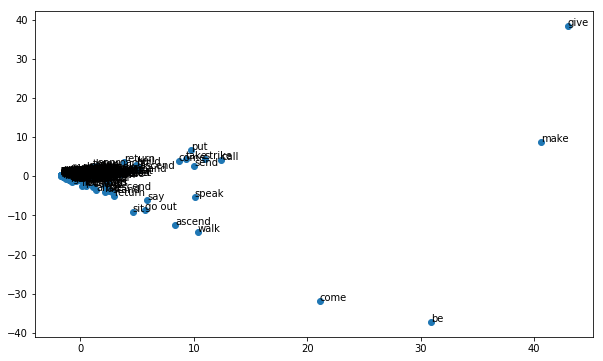

In [3]:
vfs.pmi_plot.show()

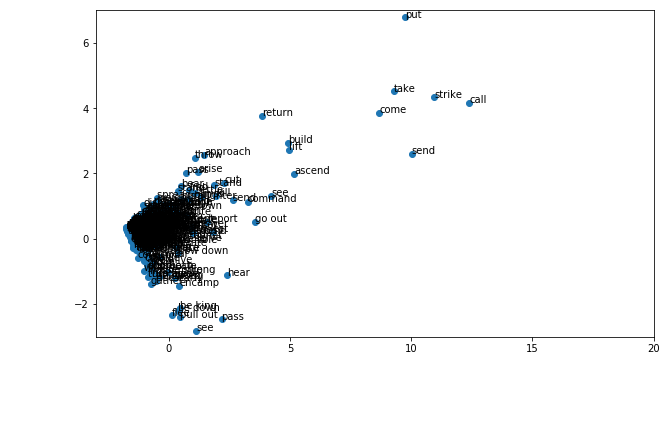

In [4]:
vfs.pmi_plot.show(axis=[-3, 20, -3, 7])

In [5]:
freq_sorted = vfs.raw.sum().sort_values(ascending=False).head(200)

In [6]:
for lex in freq_sorted.index[:10]:
    
    key = f'{lex} ({vfe.target2gloss[lex]})'
    print(vfs.similarity_pmi[key].sort_values(ascending=False).head(10))
    print()

>MR[.qal (say)            1.000000
NGD[.hof (report)         0.283769
QHL[.nif (assemble)       0.258620
XLQ[.qal (divide)         0.234295
NCQ[.qal (kiss)           0.222260
DBR[.piel (speak)         0.217854
HRH[.qal (be pregnant)    0.215494
QRB[.qal (approach)       0.213562
JDH[.hif (praise)         0.204723
Z<Q[.qal (cry)            0.200510
Name: >MR[.qal (say), dtype: float64

HJH[.qal (be)          1.000000
XLL[.hif (defile)      0.211013
>MR[.qal (say)         0.186665
CBR[.nif (break)       0.153538
KBD[.qal (be heavy)    0.150835
<FH[.qal (make)        0.148478
CM<[.qal (hear)        0.147582
KWN[.nif (be firm)     0.146613
NGD[.hif (report)      0.145950
JKL[.qal (be able)     0.143686
Name: HJH[.qal (be), dtype: float64

BW>[.qal (come)          1.000000
<LH[.qal (ascend)        0.260183
HLK[.qal (walk)          0.240671
JRD[.qal (descend)       0.210697
NWS[.qal (flee)          0.206329
JY>[.qal (go out)        0.193715
>MR[.qal (say)           0.177175
DRC[.qal (inquire

### Clustering

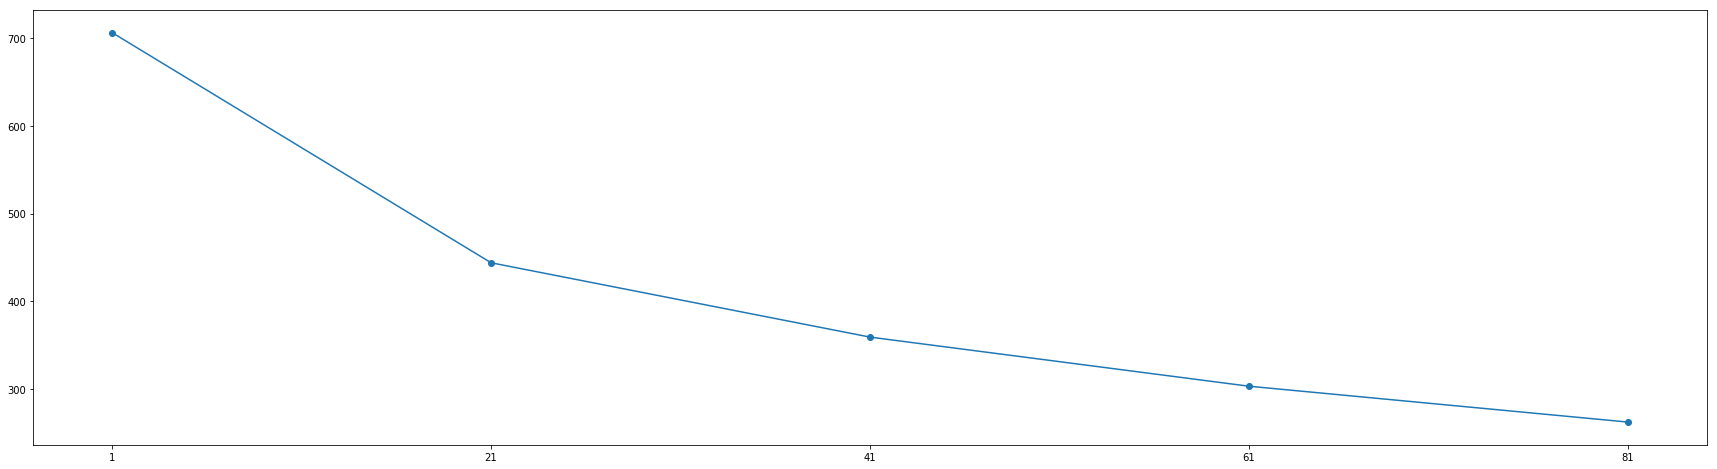

In [17]:
test = vfs.pairwise_pmi

k_to_squared = []
k_range = range(1, 100, 20)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(np.nan_to_num(test, 0))
    k_to_squared.append((k, kmeans.inertia_))
    
x = [ks[0] for ks in sorted(k_to_squared)]
y = [ks[1] for ks in sorted(k_to_squared)]
   
plt.figure(figsize=(30, 8))
ax = plt.axes()
ax.set_xticks(tuple(k_range))
plt.plot(x, y)
plt.scatter(x, y)

In [18]:
kmeans = KMeans(n_clusters=21, random_state=0).fit(np.nan_to_num(test, 0))

cglossed = pd.DataFrame(kmeans.labels_, 
                        index=[f'{F.lex.v(vfe.target2lex[w])}.{F.vs.v(vfe.target2node[w])} -- {vfe.target2gloss[w]}' for w in vfs.raw.columns], 
                        columns=['cluster']).fillna(0)

clustmin = pd.DataFrame(kmeans.labels_, 
                        index=vfs.raw.columns, 
                        columns=['cluster']).fillna(0)

gloss_to_lex = dict(zip(cglossed.index, clustmin.index))

In [19]:
clustmin.cluster.value_counts()

8     127
2      32
13     26
0      23
18     12
3      12
16     10
10      9
12      8
11      8
19      8
14      8
4       8
15      8
17      8
6       7
5       7
7       6
9       5
20      5
1       4
Name: cluster, dtype: int64

In [20]:
sorted_cluster_names = cglossed.cluster.unique()
sorted_cluster_names.sort()

for cname in sorted_cluster_names:
    
    cluster = cglossed[cglossed.cluster == cname]
    lexs = [lex.split()[0] for lex in cluster.index]
    
    
    print(f'CLUSTER {cname}')
    print(cluster.shape)
    print()
    print('TOP ARGUMENTS:')
    print(vfs.raw[lexs].sum(axis=1).sort_values(ascending=False).head(10))
    print()
    print(cluster.head(15))
    print()
    print('-'*40)

CLUSTER 0
(23, 1)

TOP ARGUMENTS:
Pred              1005.0
Pred|Cmpl.subs     338.0
Pred|Cmpl.MN       338.0
Pred|Cmpl.>L       329.0
Pred|Cmpl.B        241.0
Pred|Cmpl.<L       141.0
Pred|Cmpl.L        120.0
Pred|Cmpl.>XR/      43.0
Pred|Adju.B         41.0
Pred|Cmpl.<D        39.0
dtype: float64

                       cluster
<BR[.qal -- pass             0
<LH[.qal -- ascend           0
<MD[.qal -- stand            0
BRX[.qal -- run away         0
BW>[.qal -- come             0
CWB[.qal -- return           0
FB<[.qal -- be sated         0
GBH[.qal -- be high          0
HLK[.qal -- walk             0
JCB[.qal -- sit              0
JQY[.qal -- awake            0
JRD[.qal -- descend          0
JY>[.qal -- go out           0
KN<[.nif -- be humble        0
MHR[.piel -- hasten          0

----------------------------------------
CLUSTER 1
(4, 1)

TOP ARGUMENTS:
Pred                      150.0
Pred|Loca.B                 7.0
Pred|Adju.L                 7.0
Pred|Loca.advb              5.0
P

## Non-Subject Elements

In [21]:
bases=('Objc',)

vfe2 = VerbFrame(tf_api=tf_api, bases=bases)
print(f'verb frame experiment ready with dim {vfe2.data.shape}')
vf2 = SemSpace(vfe2, info=True)

verb frame experiment ready with dim (9, 341)
  0.00s Applying association measure(s)...
   |     0.00s Applying PPMI...
   |     0.01s Finished PPMI...
  0.01s Building pairwise matrices...
   |     0.00s Building pairwise distances...
   |     0.01s Building pairwise similarities...
  0.16s space is ready!


In [22]:
vf2.raw.sum(axis=1).sort_values(ascending=False).head(10)

Pred                        14799.0
Pred|Objc.subs               4804.0
Pred|                         428.0
Pred|Objc.subs|Objc.subs      201.0
Pred||Objc.subs                42.0
Pred|Objc.conj                 16.0
Pred|Objc.prde                 12.0
Pred|Objc.prin                  5.0
Pred|Objc.conj|Objc.subs        1.0
dtype: float64

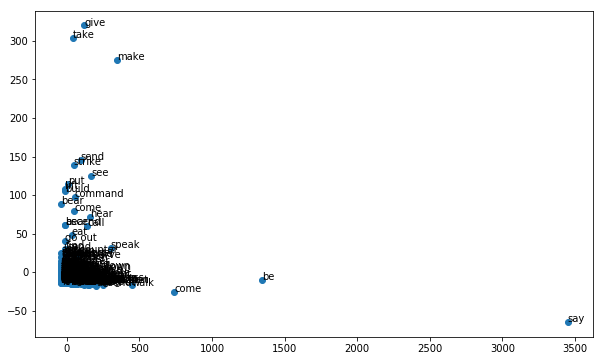

In [23]:
vf2.raw_plot.show()

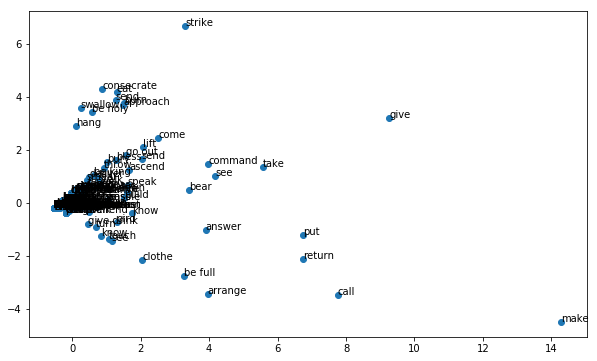

In [24]:
vf2.pmi_plot.show()

### Clustering

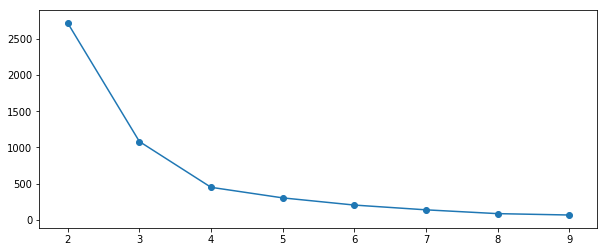

In [27]:
test = vf2.pairwise_jaccard

k_to_squared = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(np.nan_to_num(test, 0))
    k_to_squared.append((k, kmeans.inertia_))
    
x = [ks[0] for ks in sorted(k_to_squared)]
y = [ks[1] for ks in sorted(k_to_squared)]
   
plt.figure(figsize=(10, 4))
ax = plt.axes()
ax.set_xticks(tuple(k_range))
plt.plot(x, y)
plt.scatter(x, y)

In [30]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(np.nan_to_num(test, 0))

cglossed = pd.DataFrame(kmeans.labels_, 
                        index=[f'{F.lex.v(vfe2.target2lex[w])}.{F.vs.v(vfe2.target2node[w])} -- {vfe2.target2gloss[w]}' for w in vf2.raw.columns], 
                        columns=['cluster']).fillna(0)

clustmin = pd.DataFrame(kmeans.labels_, 
                        index=vf2.raw.columns, 
                        columns=['cluster']).fillna(0)

gloss_to_lex = dict(zip(cglossed.index, clustmin.index))

In [31]:
sorted_cluster_names = cglossed.cluster.unique()
sorted_cluster_names.sort()

for cname in sorted_cluster_names:
    
    cluster = cglossed[cglossed.cluster == cname]
    lexs = [lex.split()[0] for lex in cluster.index]
    
    
    print(f'CLUSTER {cname}')
    print(cluster.shape)
    print()
    print('TOP ARGUMENTS:')
    print(vf2.raw[lexs].sum(axis=1).sort_values(ascending=False).head(10))
    print()
    print(cluster.head(15))
    print()
    print('-'*40)

CLUSTER 0
(114, 1)

TOP ARGUMENTS:
Pred                        5915.0
Pred|Objc.subs               964.0
Pred||Objc.subs                0.0
Pred|Objc.subs|Objc.subs       0.0
Pred|Objc.prin                 0.0
Pred|Objc.prde                 0.0
Pred|Objc.conj|Objc.subs       0.0
Pred|Objc.conj                 0.0
Pred|                          0.0
dtype: float64

                              cluster
<MD[.qal -- stand                   0
<NH=[.piel -- be lowly              0
<RK[.qal -- arrange                 0
<WD[.hif -- warn, to witness        0
<ZR[.qal -- help                    0
>BD[.piel -- perish                 0
>BH[.qal -- want                    0
>MN[.hif -- be firm                 0
>MR[.qal -- say                     0
>WR[.hif -- be light                0
BQ<[.qal -- split                   0
BQC[.piel -- seek                   0
BXR[.qal -- examine                 0
BZH[.qal -- despise                 0
BZZ[.qal -- spoil                   0

-------------------------